In [2]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [38]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= Dense(256,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(4,activation='softmax')(x) #FC-layer

In [39]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [40]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [41]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block3_1_relu (Activation (None, 4, 4, 128)    0           conv5_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_2_conv (Conv2D)    (None, 4, 4, 32)     36864       conv5_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_concat (Concatenat (None, 4, 4, 608)    0           conv5_block2_concat[0][0]        
                                                                 conv5_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block4_0_bn (BatchNormali (None, 4, 4, 608)    2432        conv5_block3_concat[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [42]:
import nibabel as nib
import skimage.transform as skTrans

data=[]
imagePaths = sorted(list(os.listdir("data/studies")))
print(imagePaths)
for img in imagePaths:
    path=sorted(list(os.listdir("data/studies/"+img)))
    for i in path:
        img_path = "data/studies/"+str(img)+'/'+str(i)
        image = nib.load(img_path)
        image_d = image.get_fdata()
        queue = image.dataobj.shape[2]
        img_arr = skTrans.resize(image_d, (128, 128, queue), order=1, preserve_range=True)
        img_arrs = img_arr[:,:,queue//2-3:queue//2]      
        data.append((img_arrs, int(img[-1])))

['CT-0', 'CT-1', 'CT-2', 'CT-3']


In [43]:
random.seed(0)
random.shuffle(data)
image_data = []
classes = []
for d in data:
    image_data.append(d[0])
    classes.append(d[1])
image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)

In [44]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.3,random_state=42)
print(xtrain.shape, xtest.shape)

(775, 128, 128, 3) (333, 128, 128, 3)


In [45]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=256),
               steps_per_epoch=xtrain.shape[0] //256,
               epochs=100,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/100
3/3 - 15s - loss: 2.3400 - accuracy: 0.2486 - val_loss: 2.0747 - val_accuracy: 0.1135

Epoch 00001: val_loss improved from inf to 2.07465, saving model to model.h5
Epoch 2/100
3/3 - 4s - loss: 2.0786 - accuracy: 0.2486 - val_loss: 2.7091 - val_accuracy: 0.1135

Epoch 00002: val_loss did not improve from 2.07465
Epoch 3/100
3/3 - 4s - loss: 2.1108 - accuracy: 0.3083 - val_loss: 2.8556 - val_accuracy: 0.1135

Epoch 00003: val_loss did not improve from 2.07465
Epoch 4/100
3/3 - 4s - loss: 2.0467 - accuracy: 0.3295 - val_loss: 2.6442 - val_accuracy: 0.1213

Epoch 00004: val_loss did not improve from 2.07465
Epoch 5/100
3/3 - 5s - loss: 1.8580 - accuracy: 0.3438 - val_loss: 2.3417 - val_accuracy: 0.1587

Epoch 00005: val_loss did not improve from 2.07465
Epoch 6/100
3/3 - 5s - loss: 1.7676 - accuracy: 0.3622 - val_loss: 2.2063 - val_accuracy: 0.2542

Epoch 00006: val_loss did not improve from 2.07465
Epoch 7/100
3/3 - 4s - loss: 1.8061 - accuracy: 0.3776 - val_loss: 2.4151 - val

Epoch 51/100
3/3 - 5s - loss: 1.0197 - accuracy: 0.5896 - val_loss: 0.8578 - val_accuracy: 0.6606

Epoch 00051: val_loss improved from 0.86534 to 0.85785, saving model to model.h5
Epoch 52/100
3/3 - 5s - loss: 1.0668 - accuracy: 0.5838 - val_loss: 0.8673 - val_accuracy: 0.6477

Epoch 00052: val_loss did not improve from 0.85785
Epoch 53/100
3/3 - 6s - loss: 1.0608 - accuracy: 0.6042 - val_loss: 0.8833 - val_accuracy: 0.6452

Epoch 00053: val_loss did not improve from 0.85785
Epoch 54/100
3/3 - 5s - loss: 1.1017 - accuracy: 0.5915 - val_loss: 0.8871 - val_accuracy: 0.6439

Epoch 00054: val_loss did not improve from 0.85785
Epoch 55/100
3/3 - 5s - loss: 1.0407 - accuracy: 0.5761 - val_loss: 0.8805 - val_accuracy: 0.6465

Epoch 00055: val_loss did not improve from 0.85785
Epoch 56/100
3/3 - 5s - loss: 1.1466 - accuracy: 0.5626 - val_loss: 0.8781 - val_accuracy: 0.6452

Epoch 00056: val_loss did not improve from 0.85785
Epoch 57/100
3/3 - 5s - loss: 1.0203 - accuracy: 0.5819 - val_loss: 0.

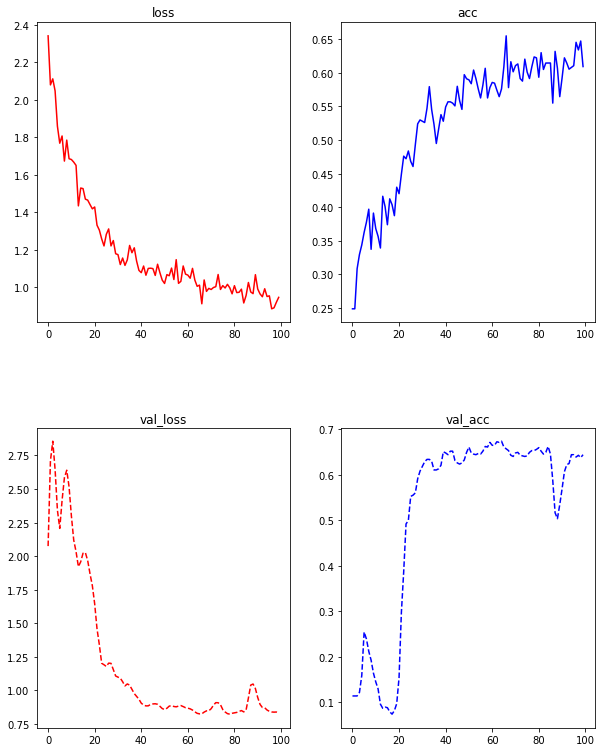

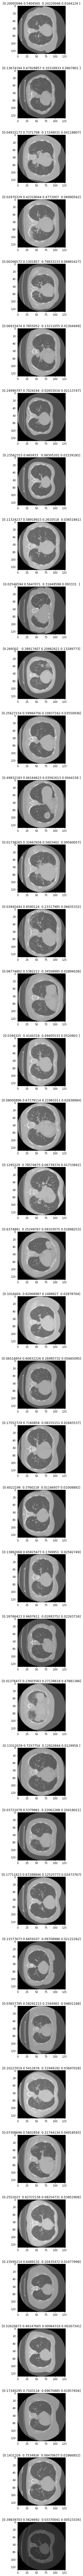

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')
    
preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

for i in range(40):
    ax1[i].imshow(xtrain[i].squeeze()[:,:,0], cmap='gray')
    ax1[i].title.set_text(str(preds[i]))

In [47]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 333 	accurately-predicted-data: 196 	 wrongly-predicted-data:  137
Accuracy: 58.859 %


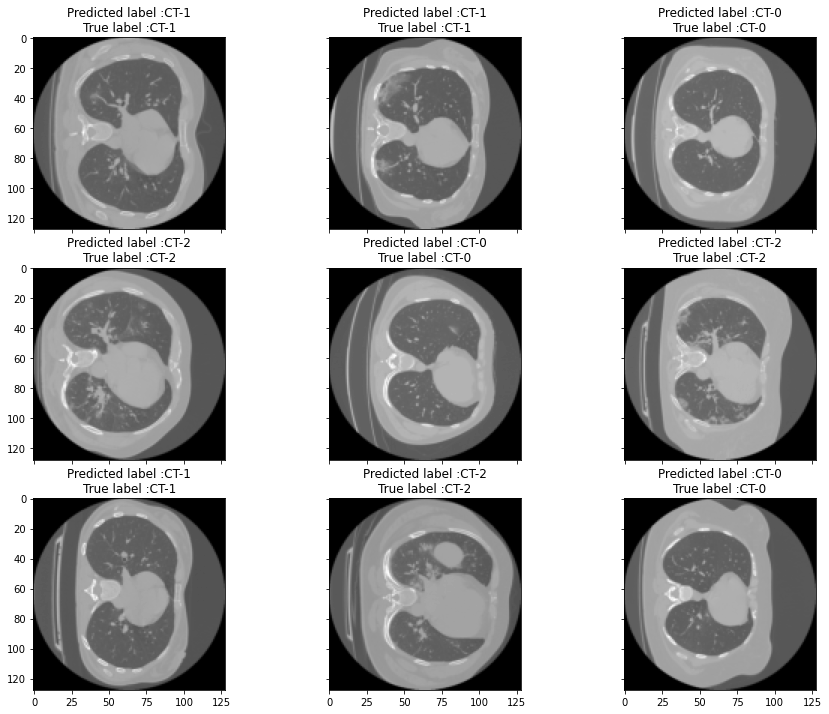

In [49]:
label = ["CT-0", "CT-1", "CT-2", "CT-3"]
imidx = random.sample(accurateindex, k=196)# replace with 'wrongindex'
res=[]
counter = 0
k = 0
for i in imidx:
    if np.argmax(ytest[i])==k:
        res.append(i)
        counter+=1
        if counter==3:
            k+=1
            counter = 0
random.shuffle(res)
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[res[n]][:,:,0], cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[res[n]])], label[np.argmax(ytest[res[n]])]))
            n += 1

plt.show()